In [1]:
# load modules (install floris)
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
import scipy
import GPy
import random
# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
%matplotlib inline

In [2]:
def multi_func(X):
    X1 = X[:,0][:,None]; X2 = X[:,1][:,None]
    f1 = 1 - np.exp(-np.square(X1-np.sqrt(1/2))-np.square(X2-np.sqrt(1/2)))
    f2 = 1 - np.exp(-np.square(X1+np.sqrt(1/2))-np.square(X2+np.sqrt(1/2)))
    Y = np.hstack((f1,f2))
    return Y

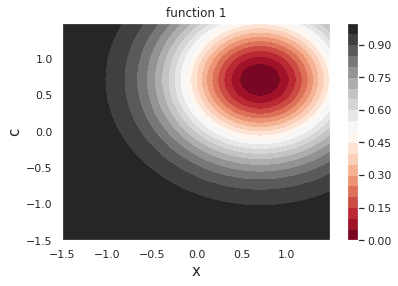

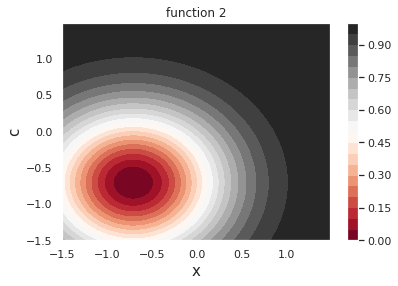

In [3]:
upper = 1.5
lower = -1.5
x_coord = np.arange(lower, upper, 0.01)
y_coord = np.arange(lower, upper, 0.01)
cont_X = np.linspace(lower, upper, 1001)
cont_Y = np.ones(len(cont_X)) * 0

x, y = np.meshgrid(x_coord, y_coord)
XX = np.hstack((x.ravel()[:,None], y.ravel()[:,None]))
f1 = multi_func(XX)[:,0].reshape(len(y_coord),len(x_coord))
f2 = multi_func(XX)[:,1].reshape(len(y_coord),len(x_coord))
plt.contourf(x, y, f1, 20, cmap='RdGy')
plt.title('function 1')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.savefig('2-1.png')
plt.show()

plt.contourf(x, y, f2, 20, cmap='RdGy')
plt.title('function 2')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.savefig('2-2.png')
plt.show()

In [4]:
def sample_next_point(acquisition, gp_model, bounds, pareto, reference, wind_dir, outdim = 2, N_mc = 5000):
    """
    acquisition : acquisition function of Gaussian processes
    gp_model : gpflow Gaussian process model
    eval_y : evaluated y list in current state
    bounds : boundary of next point
    n_restarts : number of restarts for scipy.minimize
    
    return : next x    
    """
    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, pareto, reference, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0=points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, pareto, reference, wind_dir))
    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [5]:
def hypervolume_poi(Xcand, gp_models, pareto, reference, wind_dir, outdim = 2):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1

    # Calculate Hypervolume contribution of points Y
    ub_points = np.zeros((1, num_cells*outdim))
    lb_points = np.zeros((1, num_cells*outdim))
    for i in range(len(ub_idx)):
        ub_points[0,i] = pf_ext[ub_idx[i][0],ub_idx[i][1]]
        lb_points[0,i] = pf_ext[lb_idx[i][0],lb_idx[i][1]]
    ub_points = np.reshape(ub_points, [num_cells, outdim])
    lb_points = np.reshape(lb_points, [num_cells, outdim])

    splus_valid = np.all(np.tile(np.expand_dims(ub_points, 1), [1, N, 1]) > candidate_mean,
                                axis=2)  # num_cells x N
    splus_idx = np.expand_dims(splus_valid.astype(np.float64), -1)  # num_cells x N x 1
    splus_lb = np.tile(np.expand_dims(lb_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus_lb = np.maximum(splus_lb, candidate_mean)  # num_cells x N x outdim
    splus_ub = np.tile(np.expand_dims(ub_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus = np.concatenate([splus_idx, splus_ub - splus_lb], axis=2)  # num_cells x N x (outdim+1)
    Hv = np.transpose(np.sum(np.prod(splus, axis=2), axis=0, keepdims=True))  # N x 1
    
    # return HvPoI
    return -np.multiply(Hv, PoI)

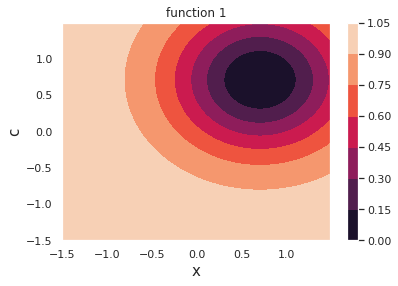

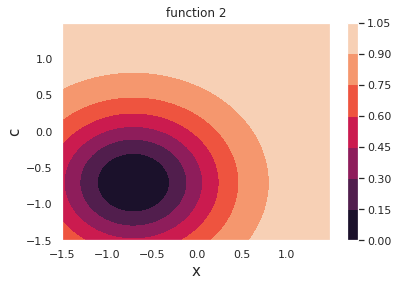

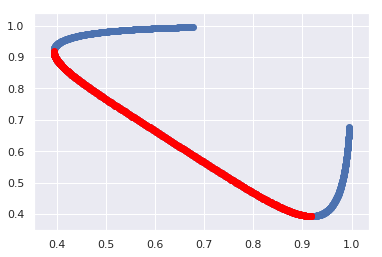

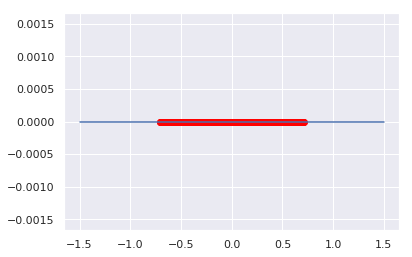

In [6]:
upper = 1.5
lower = -1.5
x_coord = np.arange(lower, upper, 0.01)
y_coord = np.arange(lower, upper, 0.01)
cont_X = np.linspace(lower, upper, 1001)
cont_Y = np.ones(len(cont_X)) * 0

x, y = np.meshgrid(x_coord, y_coord)
XX = np.hstack((x.ravel()[:,None], y.ravel()[:,None]))
f1 = multi_func(XX)[:,0].reshape(len(y_coord),len(x_coord))
f2 = multi_func(XX)[:,1].reshape(len(y_coord),len(x_coord))
plt.contourf(x, y, f1)
plt.title('function 1')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.show()
plt.contourf(x, y, f2)
plt.title('function 2')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.show()

pareto = Pareto(np.empty((0,2)))

f1f2 = multi_func(np.hstack((cont_X[:,None], cont_Y[:,None])))
pareto.update(f1f2)
plt.scatter(f1f2[:,0], f1f2[:,1])
plt.scatter(pareto.front[:,0], pareto.front[:,1], color = 'red')
plt.show()

idx = np.array([i for i in range(len(f1f2)) if f1f2[i,0] in pareto.front[:,0]])
plt.plot(cont_X, cont_Y)
plt.scatter(cont_X[idx], cont_Y[idx], color = 'red')
plt.show()

## Input space plot

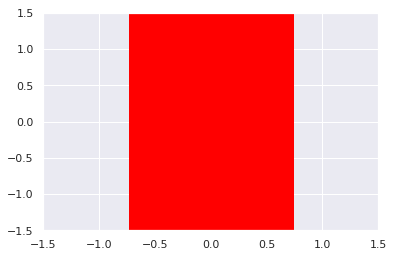

In [7]:
opt_x = []
opt_y = []
for c in np.linspace(lower, upper, 1001):
    test_X = np.linspace(lower, upper, 1001)
    test_Y = np.ones(len(cont_X)) * c
    
    pareto = Pareto(np.empty((0,2)))
    f_value = multi_func(np.hstack((test_X[:,None], test_Y[:,None])))
    pareto.update(f_value)
    
    idx = np.array([i for i in range(len(f_value)) if f_value[i,0] in pareto.front[:,0] and f_value[i,1] in pareto.front[:,1]])
    opt_x.extend(test_X[idx])
    opt_y.extend(test_Y[idx])

plt.scatter(opt_x, opt_y, marker = 's', color = 'red')
plt.xlim([lower, upper])
plt.ylim([lower, upper])
plt.show()

In [8]:
# target_c = np.random.uniform(-1, 1)
target_c = 0.10575967913003392
print(target_c)

0.10575967913003392


In [9]:
minimum = -1.5
maximum = 1.5

bounds = np.array([[minimum, maximum]])

# initial data point of wind-farm
init_sample = 1
c_init = np.array([[target_c]])
X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, c_init))
Y = multi_func(X)

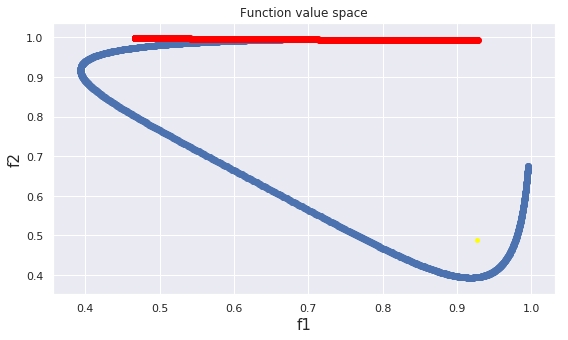

In [10]:
plt.figure(figsize=(9,5))
plt.title('Function value space')
plt.xlabel('f1', fontsize = 15)
plt.ylabel('f2', fontsize = 15)
plt.scatter(f1f2[:,0], f1f2[:,1], label = 'function values')
plt.scatter(pareto.front[:,0], pareto.front[:,1], color = 'red', label = 'pareto front of function values')
plt.scatter(Y[:,0], Y[:,1], s=15, color = 'yellow', label = 'BO values')
plt.show()

In [11]:
num_output = Y.shape[1]
num_iter = 300
n_params = bounds.shape[0] + 1
# c_context = np.random.choice(context_list.flatten(), num_iter)[:,None]
c_context = np.random.uniform(-1, 1, size=(num_iter, 1))
for i in range(len(c_context)):
    if i % 5 == 0:
        c_context[i] = target_c

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)+GPy.kern.RBF(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for model in gp_models:
        model.optimize()
    context_X = np.hstack((X[:,:-1], np.ones((len(X), 1)) * c_context[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(Y)
    
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, c_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * c_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multi_func(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.

In [12]:
sns.set_style("whitegrid", {'axes.grid' : False})

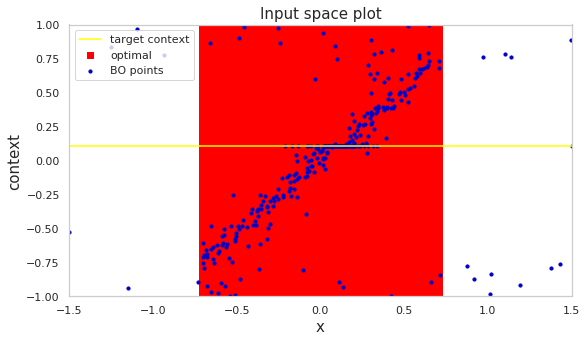

In [13]:
plt.figure(figsize=(9,5))
plt.title('Input space plot', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('context', fontsize=15)
plt.scatter(opt_x, opt_y, marker = 's', color = 'red', label = 'optimal')
# plt.scatter(X[:init_sample][:,0], X[:init_sample][:,1], color = 'black', marker = 'x', label = 'inital sample')
plt.scatter(X[init_sample:][:,0], X[init_sample:][:,1], s = 10, color = 'mediumblue', label = 'BO points')
plt.plot([-1.5, 1.5], [target_c, target_c], color = 'yellow', label = 'target context')
plt.xlim([-1.5, 1.5])
plt.ylim([-1,1])
plt.legend(loc = 2)
plt.show()

selected c: 0.10575967913003392


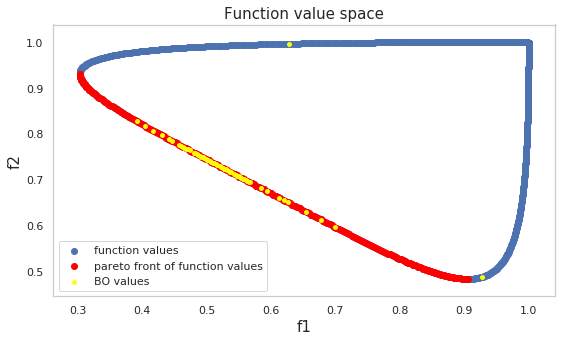

In [14]:
idx = [i for i in range(len(X)) if X[i][-1] == target_c]
# selected_c = np.random.uniform(-np.pi, np.pi)
print('selected c:', target_c)
cont_X = np.linspace(-np.pi,np.pi,1001)
cont_Y = np.ones(len(cont_X)) * target_c


pareto = Pareto(np.empty((0,2)))
f1f2 = multi_func(np.hstack((cont_X[:,None], cont_Y[:,None])))
pareto.update(f1f2)
# current_x_in_c = [list(i) for i in X[init_sample:] if i[1] == selected_c]

plt.figure(figsize=(9,5))
plt.title('Function value space', fontsize=15)
plt.xlabel('f1', fontsize = 15)
plt.ylabel('f2', fontsize = 15)
plt.scatter(f1f2[:,0], f1f2[:,1], label = 'function values')
plt.scatter(pareto.front[:,0], pareto.front[:,1], color = 'red', label = 'pareto front of function values')
plt.scatter(Y[idx][:,0], Y[idx][:,1], s=15, color = 'yellow', label = 'BO values')
plt.legend(loc = 3)
plt.show()


In [15]:
err = []
for i in range(len(idx)):
    err.append(np.min(np.linalg.norm(pareto.front - Y[idx[i]],axis=1)))


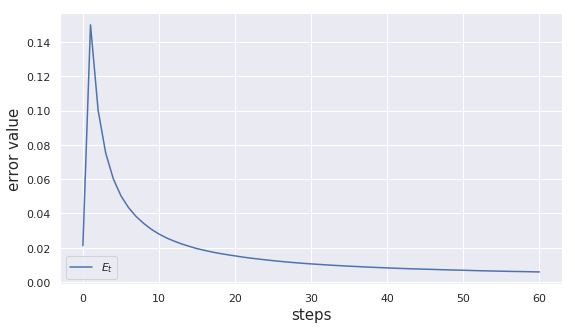

In [16]:
sns.set()
idx = [i for i in range(len(X)) if X[i][-1] == target_c]
cum_err = np.zeros(len(err))
for i in range(len(err)):
    cum_err[i] = np.sum(err[:i+1]) / (i+1)
plt.figure(figsize=(9,5))
plt.plot(cum_err, label = r'$E_{t}$')
plt.xlabel('steps', fontsize=15)
plt.ylabel('error value', fontsize=15)
plt.legend(loc=3)
plt.show()

In [22]:
def EHVI(Xcand, gp_models, pareto, reference, wind_dir, outdim = 2):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))

    ext1, ext2 = np.array([[-np.inf, reference[0][1]]]), np.array([[reference[0][0], -np.inf]])
    pf_ext = np.concatenate([ext1, pareto.front, ext2], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    normal1 = scipy.stats.norm(candidate_mean[:,0], np.sqrt(candidate_var[:,0]))
    normal2 = scipy.stats.norm(candidate_mean[:,1], np.sqrt(candidate_var[:,1]))
    
    P1 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    P2 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    
    for i in range(len(pareto.front)+1):
        if i == 0:
            P1[:,i] = 0
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)
        else:
            P1[:,i] = (pf_ext[i+1, 0] - pf_ext[i, 0]) * normal1.cdf(pf_ext[i, 0]) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2) 
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)

            
    return -np.sum(P1 + P2, axis = 1)[:,None]

def exipsi(a, b, normal):
    return normal.std() * normal.pdf(b) + (a-normal.mean()) * normal.cdf(b)

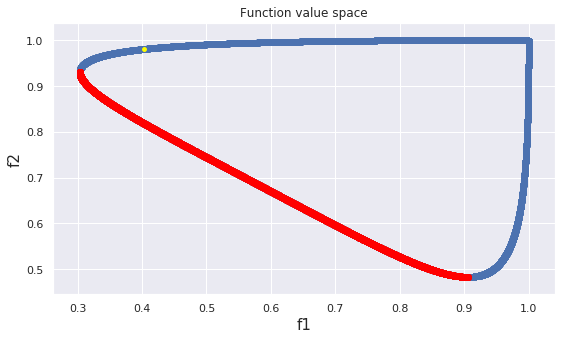

In [24]:
init_sample = 1
c_init = np.array([[target_c]])
X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, c_init))
Y = multi_func(X)



cont_X = np.linspace(-np.pi,np.pi,10001)
cont_Y = np.ones(len(cont_X)) * target_c

pareto = Pareto(np.empty((0,2)))
f1f2 = multi_func(np.hstack((cont_X[:,None], cont_Y[:,None])))
pareto.update(f1f2)

plt.figure(figsize=(9,5))
plt.title('Function value space')
plt.xlabel('f1', fontsize = 15)
plt.ylabel('f2', fontsize = 15)
plt.scatter(f1f2[:,0], f1f2[:,1], label = 'function values')
plt.scatter(pareto.front[:,0], pareto.front[:,1], color = 'red', label = 'pareto front of function values')
plt.scatter(Y[:1,0], Y[:1,1], s=15, color = 'yellow', label = 'BO values')
plt.show()

In [25]:
num_output = Y.shape[1]
num_iter = 300
n_params = bounds.shape[0] + 1
# c_context = np.random.choice(context_list.flatten(), num_iter)[:,None]
c_context = np.random.uniform(-1, 1, size=(num_iter, 1))
for i in range(len(c_context)):
    if i % 5 == 0:
        c_context[i] = target_c

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)+GPy.kern.RBF(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for model in gp_models:
        model.optimize()
    context_X = np.hstack((X[:,:-1], np.ones((len(X), 1)) * c_context[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(Y)
    
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    
    next_point = np.atleast_2d(sample_next_point(EHVI, gp_models, bounds, pareto, reference, c_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * c_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multi_func(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


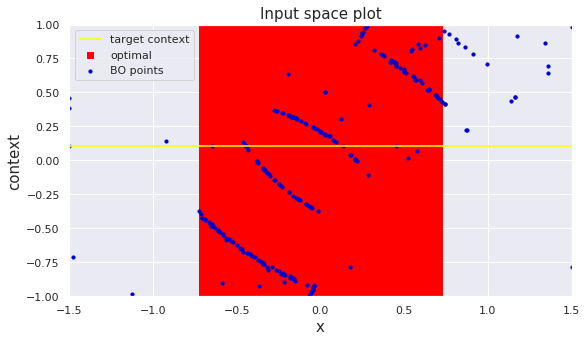

In [26]:
plt.figure(figsize=(9,5))
plt.title('Input space plot', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('context', fontsize=15)
plt.scatter(opt_x, opt_y, marker = 's', color = 'red', label = 'optimal')
# plt.scatter(X[:init_sample][:,0], X[:init_sample][:,1], color = 'black', marker = 'x', label = 'inital sample')
plt.scatter(X[init_sample:][:,0], X[init_sample:][:,1], s = 10, color = 'mediumblue', label = 'BO points')
plt.plot([-1.5, 1.5], [target_c, target_c], color = 'yellow', label = 'target context')
plt.xlim([-1.5, 1.5])
plt.ylim([-1,1])
plt.legend(loc = 2)
plt.show()

selected c: 0.10575967913003392


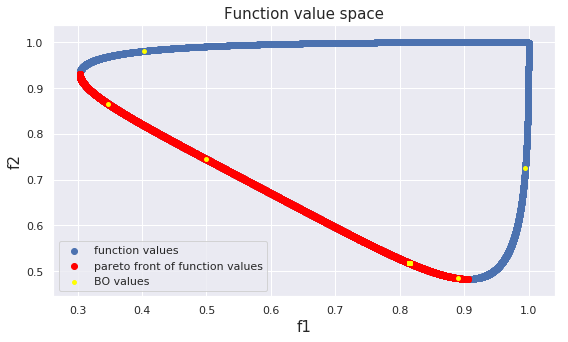

In [27]:
idx = [i for i in range(len(X)) if X[i][-1] == target_c]
# selected_c = np.random.uniform(-np.pi, np.pi)
print('selected c:', target_c)
cont_X = np.linspace(-np.pi, np.pi,10001)
cont_Y = np.ones(len(cont_X)) * target_c


pareto = Pareto(np.empty((0,2)))
f1f2 = multi_func(np.hstack((cont_X[:,None], cont_Y[:,None])))
pareto.update(f1f2)
# current_x_in_c = [list(i) for i in X[init_sample:] if i[1] == selected_c]

plt.figure(figsize=(9,5))
plt.title('Function value space', fontsize=15)
plt.xlabel('f1', fontsize = 15)
plt.ylabel('f2', fontsize = 15)
plt.scatter(f1f2[:,0], f1f2[:,1], label = 'function values')
plt.scatter(pareto.front[:,0], pareto.front[:,1], color = 'red', label = 'pareto front of function values')
plt.scatter(Y[idx][:,0], Y[idx][:,1], s=15, color = 'yellow', label = 'BO values')
plt.legend(loc = 3)
plt.show()